Richard Schwarcz, 2.NKDS
# 3.Zadanie

In [49]:
import os
import sys

__file__ = os.path.abspath('3.zadanie.ipynb')
baseName = os.path.basename(__file__)
dirName = os.path.dirname(__file__)
sys.path.append(dirName + r'/..')

In [50]:
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.precision", 4)

from modules.helpers import *
from modules.Z3.model import * 

In [5]:
# lano
L = 60 #m
H = 4 #m 
FI = 20 #mm
E = 165*10**6 #kPa

# sila
P = 300 #kN

# Lineárny výpočet

In [6]:
barProperties = BarProps(FI, E)
print(f'A = {barProperties.A} m2')

A = 0.0003141592653589793 m2


In [7]:
p1 = Point(x=0, y=0, number=1)
p2 = Point(x=L/2, y=-H, number=2)
p3 = Point(x=L, y=0, number=3)

In [8]:
b1 = Bar_linear(point_a=p1, point_b=p2, bar_props=barProperties)
b2 = Bar_linear(point_a=p2, point_b=p3, bar_props=barProperties)
print(f'lenght of bar 1 = {b1.len:.3f} m\nlenght of bar 2 = {b2.len:.3f} m\nangle of bar 1 = {b1.angle:.5f} rad\nangle of bar 2 = {b2.angle:.5f} rad')

lenght of bar 1 = 30.265 m
lenght of bar 2 = 30.265 m
angle of bar 1 = -0.13255 rad
angle of bar 2 = 0.13255 rad


Text(45.13274595042156, -2.0, 'fi = 0.000314 m')

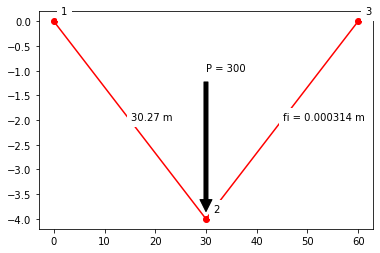

In [9]:
plt.plot([p1.x, p2.x, p3.x], [p1.y, p2.y, p3.y], 'ro-')
for p in [p1, p2, p3]:
    plt.annotate(f'{p.number}', (p.x, p.y), xytext=(7, 7), textcoords='offset points', backgroundcolor='white')

plt.annotate(f'P = {P}', xy=(p2.x, p2.y), xytext=(p2.x, p2.y + P/100), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'{b1.len:.2f} m', xy=(p1.x, p1.y), xytext=(p1.x + b1.len/2, p1.y-H/2), backgroundcolor='white')
plt.annotate(f'fi = {barProperties.A:.6f} m', xy=(p2.x, p2.y), xytext=(p2.x + b2.len/2, p2.y+H/2), backgroundcolor='white')

In [10]:
b1.stiffnessMatrix_GSS['matrix']

,0,1,2,3,4,5
0,1682.8024,-224.3736,0.0,-1682.8024,224.3736,0.0
1,-224.3736,29.9165,0.0,224.3736,-29.9165,0.0
2,0.0000,0.0000,0.0,0.0000,0.0000,0.0
3,-1682.8024,224.3736,0.0,1682.8024,-224.3736,0.0
4,224.3736,-29.9165,0.0,-224.3736,29.9165,0.0
5,0.0000,0.0000,0.0,0.0000,0.0000,0.0


In [11]:
b2.stiffnessMatrix_GSS['matrix']

,0,1,2,3,4,5
0,1682.8024,224.3736,0.0,-1682.8024,-224.3736,0.0
1,224.3736,29.9165,0.0,-224.3736,-29.9165,0.0
2,0.0000,0.0000,0.0,0.0000,0.0000,0.0
3,-1682.8024,-224.3736,0.0,1682.8024,224.3736,0.0
4,-224.3736,-29.9165,0.0,224.3736,29.9165,0.0
5,0.0000,0.0000,0.0,0.0000,0.0000,0.0


In [12]:
kbb = b1.stiffnessMatrix_GSS['kbb']
kaa = b2.stiffnessMatrix_GSS['kaa']
K = kbb + kaa
K

array([[3365.60474663,    0.        ,    0.        ],
       [   0.        ,   59.83297327,    0.        ],
       [   0.        ,    0.        ,    0.        ]])

In [13]:
# drop last column and row to be able to calculate inverse matrix
K = K[:-1, :-1]
K_inv = np.linalg.inv(K)
K_inv

array([[0.00029712, 0.        ],
       [0.        , 0.01671319]])

In [14]:
displacements = K_inv @ np.array([[0], [P]])
print(f'displacement of point 1 = {displacements[0][0]:.2f} m\ndisplacement of point 2 = {displacements[1][0]:.2f} m')

displacement of point 1 = 0.00 m
displacement of point 2 = 5.01 m


Koncove sily

In [15]:
kab = b1.stiffnessMatrix_GSS['kab'][:-1, :-1]
Fa = kab @ displacements
# print end forces
print(f'end force of bar 1 point 1 = {Fa[0][0]:.2f} kN\nend force of bar 1 point 2 = {Fa[1][0]:.2f} kN')

end force of bar 1 point 1 = 1125.00 kN
end force of bar 1 point 2 = -150.00 kN


In [16]:
kbb = b1.stiffnessMatrix_GSS['kbb'][:-1, :-1]
Fb = kbb @ displacements
# print end forces
print(f'end force of bar 2 point 1 = {Fb[0][0]:.2f} kN\nend force of bar 2 point 2 = {Fb[1][0]:.2f} kN')

end force of bar 2 point 1 = -1125.00 kN
end force of bar 2 point 2 = 150.00 kN


vnutorne sily

In [17]:
intF = b1.A0_matrix[:-1, :-1] @ Fb
print(f'N = {intF[0][0]:.2f} kN')

N = -1134.96 kN


# Nelineárny výpočet
## 1. Prírastok

In [18]:
barProperties = BarProps(FI, E)

In [19]:
p1_1 = Point(x=0, y=0, number=1)
p2_1 = Point(x=L/2, y=H, number=2)
p3_1 = Point(x=L, y=0, number=3)

In [20]:
b1_1 = Bar(point_a=p1_1, point_b=p2_1, bar_props=barProperties)
b2_1 = Bar(point_a=p2_1, point_b=p3_1, bar_props=barProperties)

In [21]:
b1_1.stiffnessMatrix_GSS

array([[ 1682.80237331,   224.37364978, -1682.80237331,  -224.37364978],
       [  224.37364978,    29.91648664,  -224.37364978,   -29.91648664],
       [-1682.80237331,  -224.37364978,  1682.80237331,   224.37364978],
       [ -224.37364978,   -29.91648664,   224.37364978,    29.91648664]])

In [22]:
def totalStiffnessMatrix_GSS(bars):
    # create 6x6 matrix of zeros because we have 3 points and each point has 2 DOF
    stiffnessMatrix = np.zeros((6, 6))
    # fill matrix with values of bar1
    stiffnessMatrix[0:4, 0:4] = bars[0].stiffnessMatrix_GSS
    # fill matrix with values of bar2 and sum with values of bar1
    stiffnessMatrix[2:6, 2:6] += bars[1].stiffnessMatrix_GSS
    # print matrix and round values to 2 decimal places
    return stiffnessMatrix.round(2)


In [23]:
stiffnessMatrix = totalStiffnessMatrix_GSS([b1_1, b2_1])
stiffnessMatrix

array([[ 1682.8 ,   224.37, -1682.8 ,  -224.37,     0.  ,     0.  ],
       [  224.37,    29.92,  -224.37,   -29.92,     0.  ,     0.  ],
       [-1682.8 ,  -224.37,  3365.6 ,     0.  , -1682.8 ,   224.37],
       [ -224.37,   -29.92,     0.  ,    59.83,   224.37,   -29.92],
       [    0.  ,     0.  , -1682.8 ,   224.37,  1682.8 ,  -224.37],
       [    0.  ,     0.  ,   224.37,   -29.92,  -224.37,    29.92]])

In [24]:
loadVector = Load(3, 3, 300).vector
loadVector

array([[  0.],
       [  0.],
       [  0.],
       [100.],
       [  0.],
       [  0.]])

In [25]:
def displacementVector(stiffnessMatrix, loadVector):
    # inverse matrix of stiffnessMatrix at point 2 and multiply with loadVector at point 2
    return np.linalg.inv(stiffnessMatrix[2:4, 2:4]) @ loadVector[2:4]

In [26]:
displacementVector_1 = displacementVector(stiffnessMatrix, loadVector)
displacementVector_1

array([[0.        ],
       [1.67140231]])

In [27]:
b1_1.points_displacements_setter(point_a=np.array([[0], [0]]), point_b=displacementVector_1)
b2_1.points_displacements_setter(point_a=displacementVector_1, point_b=np.array([[0], [0]]))

In [28]:
b1_1_intF = b1_1.internal_forces
b1_1_intF

array([[-3.78337449e+02],
       [ 7.10542736e-15],
       [ 3.78337449e+02],
       [-7.10542736e-15]])

## 2. Prírastok

In [29]:
H_2 = H+displacementVector_1[1][0]
print(f'H_2 = {H_2:.2f} m')

H_2 = 5.67 m


In [30]:
p1_2 = Point(x=0, y=0, number=1)
p2_2 = Point(x=L/2, y=H_2, number=2)
p3_2 = Point(x=L, y=0, number=3)

In [31]:
b1_2 = Bar(point_a=p1_2, point_b=p2_2, bar_props=barProperties)
b2_2 = Bar(point_a=p2_2, point_b=p3_2, bar_props=barProperties)

In [32]:
F1 = b1_1.internal_forces[0][0]
F2 = (b1_1.bar_props.E*b1_1.bar_props.A/(b1_2.len))*(b1_2.len-b1_1.len)
b1_2.F = [F1, F2, 0]
b2_2.F = [F1, F2, 0]

In [33]:
b1_2.stiffnessMatrix_GSS

array([[ 1640.15787259,   304.92876863, -1640.15787259,  -304.92876863],
       [  304.92876863,    84.82285815,  -304.92876863,   -84.82285815],
       [-1640.15787259,  -304.92876863,  1640.15787259,   304.92876863],
       [ -304.92876863,   -84.82285815,   304.92876863,    84.82285815]])

In [34]:
stiffnessMatrix = totalStiffnessMatrix_GSS([b1_2, b2_2])
stiffnessMatrix

array([[ 1640.16,   304.93, -1640.16,  -304.93,     0.  ,     0.  ],
       [  304.93,    84.82,  -304.93,   -84.82,     0.  ,     0.  ],
       [-1640.16,  -304.93,  3280.32,     0.  , -1640.16,   304.93],
       [ -304.93,   -84.82,     0.  ,   169.65,   304.93,   -84.82],
       [    0.  ,     0.  , -1640.16,   304.93,  1640.16,  -304.93],
       [    0.  ,     0.  ,   304.93,   -84.82,  -304.93,    84.82]])

In [35]:
displacementVector_2 = displacementVector(stiffnessMatrix, loadVector)
displacementVector_2

array([[0.        ],
       [0.58944887]])

In [36]:
b1_2.points_displacements_setter(point_a=np.array([[0], [0]]), point_b=displacementVector_2)
b2_2.points_displacements_setter(point_a=displacementVector_2, point_b=np.array([[0], [0]]))

In [37]:
b1_2_intF = b1_2.internal_forces + b1_1_intF
b1_2_intF

array([[-564.23672923],
       [ -15.74068515],
       [ 564.23672923],
       [  15.74068515]])

## 3. Prírastok

In [38]:
H_3 = H + displacementVector_1[1][0] + displacementVector_2[1][0]
print(f'H_3 = {H_3:.2f} m')

H_3 = 6.26 m


In [39]:
p1_3 = Point(x=0, y=0, number=1)
p2_3 = Point(x=L/2, y=H_3, number=2)
p3_3 = Point(x=L, y=0, number=3)

In [40]:
b1_3 = Bar(point_a=p1_3, point_b=p2_3, bar_props=barProperties)
b2_3 = Bar(point_a=p2_3, point_b=p3_3, bar_props=barProperties)

In [41]:
F1 = F1
F2 = F2
F3 = (b1_3.bar_props.E*b1_3.bar_props.A/(b1_3.len))*(b1_3.len-b1_2.len)
b1_3.F = [F1, F2, F3]
b2_3.F = [F1, F2, F3]

In [42]:
b1_3.stiffnessMatrix_GSS

array([[ 1622.23581252,   331.57789236, -1622.23581252,  -331.57789236],
       [  331.57789236,   102.61907182,  -331.57789236,  -102.61907182],
       [-1622.23581252,  -331.57789236,  1622.23581252,   331.57789236],
       [ -331.57789236,  -102.61907182,   331.57789236,   102.61907182]])

In [43]:
stiffnessMatrix = totalStiffnessMatrix_GSS([b1_3, b2_3])
stiffnessMatrix

array([[ 1622.24,   331.58, -1622.24,  -331.58,     0.  ,     0.  ],
       [  331.58,   102.62,  -331.58,  -102.62,     0.  ,     0.  ],
       [-1622.24,  -331.58,  3244.47,     0.  , -1622.24,   331.58],
       [ -331.58,  -102.62,     0.  ,   205.24,   331.58,  -102.62],
       [    0.  ,     0.  , -1622.24,   331.58,  1622.24,  -331.58],
       [    0.  ,     0.  ,   331.58,  -102.62,  -331.58,   102.62]])

In [44]:
displacementVector_3 = displacementVector(stiffnessMatrix, loadVector)
displacementVector_3

array([[0.        ],
       [0.48723446]])

In [45]:
b1_3.points_displacements_setter(point_a=np.array([[0], [0]]), point_b=displacementVector_3)
b2_3.points_displacements_setter(point_a=displacementVector_3, point_b=np.array([[0], [0]]))

In [46]:
b1_3_intF = b1_3.internal_forces + b1_2_intF
b1_3_intF

array([[-732.60021666],
       [ -31.68083469],
       [ 732.60021666],
       [  31.68083469]])

## Vnútorné sily na prúte 1

In [47]:
f_dict = {
    '1.prirastok' : b1_1_intF.flatten(),
    '2.prirastok' : b1_2_intF.flatten(),
    '3.prirastok' : b1_3_intF.flatten(),
}
pd.DataFrame(f_dict)

,1.prirastok,2.prirastok,3.prirastok
0,-3.7834e+02,-564.2367,-732.6002
1,7.1054e-15,-15.7407,-31.6808
2,3.7834e+02,564.2367,732.6002
3,-7.1054e-15,15.7407,31.6808


## Deformácie v bode 2

In [48]:
d_dict = {
    '1.prirastok' : displacementVector_1.flatten(),
    '2.prirastok' : displacementVector_2.flatten(),
    '3.prirastok' : displacementVector_3.flatten(),
}
parseMatrixRows(pd.DataFrame(d_dict), ['u', 'v'])

,1.prirastok,2.prirastok,3.prirastok
u,0.0000,0.0000,0.0000
v,1.6714,0.5894,0.4872


# Normálové sily z dlubalu

N - po prvom prírastku
---
![N](..\assets\Z3\N_1.png)
---
N - po druhom prírastku
---
![N](..\assets\Z3\N_2.png)
---
N - po treťom prírastku
---
![N](..\assets\Z3\N_3.png)

# Zvislé deformácie z dlubalu

v - po prvom prírastku
---
![N](..\assets\Z3\v_1.png)
---
v - po druhom prírastku
---
![N](..\assets\Z3\v_2.png)
---
v - po treťom prírastku
---
![N](..\assets\Z3\v_3.png)